In [86]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [87]:

# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [88]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np
SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [89]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [90]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [91]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [92]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [93]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [94]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo,x_azar,y_azar,cv=cv,groups= dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


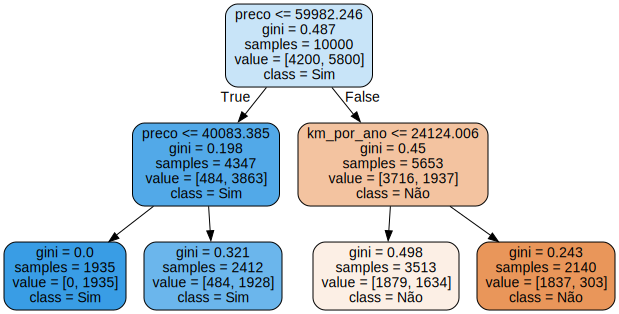

In [95]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar,y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                           class_names=["Não","Sim"],
                           feature_names= features)
graph = graphviz.Source(dot_data)
graph

Testando parametros

In [96]:
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo,x_azar,y_azar,cv=cv,groups= dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean()* 100
    print("max_depth = %d, media = %.2f , teste = %.2f" % (max_depth,test_score, train_score))
    tabela = [max_depth,test_score, train_score]
    return tabela





In [97]:
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados,columns=["max_depth","train","test"])
resultados.head()

max_depth = 1, media = 75.78 , teste = 75.79
max_depth = 2, media = 75.78 , teste = 75.79
max_depth = 3, media = 78.67 , teste = 78.75
max_depth = 4, media = 78.63 , teste = 78.79
max_depth = 5, media = 78.56 , teste = 78.94
max_depth = 6, media = 78.12 , teste = 79.17
max_depth = 7, media = 77.96 , teste = 79.50
max_depth = 8, media = 77.86 , teste = 79.89
max_depth = 9, media = 77.38 , teste = 80.46
max_depth = 10, media = 77.19 , teste = 81.16
max_depth = 11, media = 76.97 , teste = 82.03
max_depth = 12, media = 76.49 , teste = 82.89
max_depth = 13, media = 75.81 , teste = 83.95
max_depth = 14, media = 75.66 , teste = 85.03
max_depth = 15, media = 75.16 , teste = 86.14
max_depth = 16, media = 75.11 , teste = 87.19
max_depth = 17, media = 74.74 , teste = 88.31
max_depth = 18, media = 74.33 , teste = 89.26
max_depth = 19, media = 74.34 , teste = 90.32
max_depth = 20, media = 74.22 , teste = 91.32
max_depth = 21, media = 73.80 , teste = 92.14
max_depth = 22, media = 73.81 , teste = 93.

,max_depth,train,test
0,1,75.784219,75.791169
1,2,75.784219,75.791169
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007


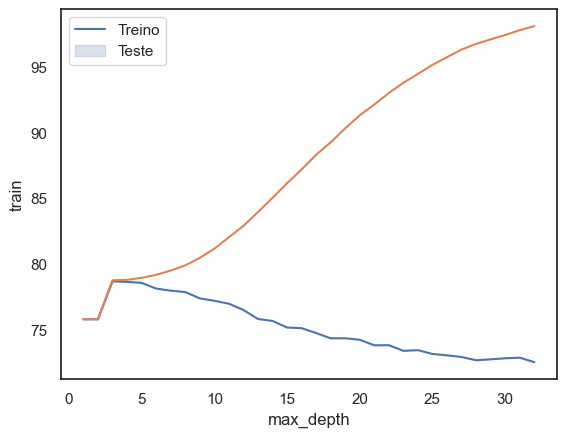

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x= "max_depth",y= "train", data = resultados)
sns.lineplot(x= "max_depth",y="test",data = resultados)
plt.legend(["Treino","Teste"])

In [99]:
resultados.sort_values("train",ascending=False).head()

,max_depth,train,test
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007
5,6,78.123266,79.170115
6,7,77.963185,79.496806


In [100]:
def roda_arvore_de_decisao(max_depth,min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo,x_azar,y_azar,cv=cv,groups= dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean()* 100
    print("max_depth = %d, min_samples_leaf = %.2f , media = %.2f , teste = %.2f" % (max_depth,min_samples_leaf,test_score, train_score))
    tabela = [max_depth,min_samples_leaf,test_score, train_score]
    return tabela

In [101]:
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64 , 128 ,256]:
            tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados,columns=["max_depth","min_samples_leaf","train","test"])
    return resultados

resultados = busca()
resultados.head()

max_depth = 1, min_samples_leaf = 32.00 , media = 75.78 , teste = 75.79
max_depth = 1, min_samples_leaf = 64.00 , media = 75.78 , teste = 75.79
max_depth = 1, min_samples_leaf = 128.00 , media = 75.78 , teste = 75.79
max_depth = 1, min_samples_leaf = 256.00 , media = 75.78 , teste = 75.79
max_depth = 2, min_samples_leaf = 32.00 , media = 75.78 , teste = 75.79
max_depth = 2, min_samples_leaf = 64.00 , media = 75.78 , teste = 75.79
max_depth = 2, min_samples_leaf = 128.00 , media = 75.78 , teste = 75.79
max_depth = 2, min_samples_leaf = 256.00 , media = 75.78 , teste = 75.79
max_depth = 3, min_samples_leaf = 32.00 , media = 78.67 , teste = 78.75
max_depth = 3, min_samples_leaf = 64.00 , media = 78.67 , teste = 78.75
max_depth = 3, min_samples_leaf = 128.00 , media = 78.67 , teste = 78.75
max_depth = 3, min_samples_leaf = 256.00 , media = 78.67 , teste = 78.75
max_depth = 4, min_samples_leaf = 32.00 , media = 78.67 , teste = 78.75
max_depth = 4, min_samples_leaf = 64.00 , media = 78.67 , 

,max_depth,min_samples_leaf,train,test
0,1,32,75.784219,75.791169
1,1,64,75.784219,75.791169
2,1,128,75.784219,75.791169
3,1,256,75.784219,75.791169
4,2,32,75.784219,75.791169


In [102]:
resultados.sort_values(['test'],ascending=False).head()


,max_depth,min_samples_leaf,train,test
112,29,32,76.844252,80.891161
124,32,32,76.844252,80.891161
120,31,32,76.844252,80.891161
96,25,32,76.844252,80.891161
100,26,32,76.844252,80.891161


In [103]:
resultados.corr()

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,-0.027675,0.536705
min_samples_leaf,-2.780775e-16,1.000000e+00,0.349011,-0.409676
train,-2.767507e-02,3.490111e-01,1.000000,0.116466
test,5.367048e-01,-4.096762e-01,0.116466,1.000000


Explorando 3 dimensões de hiper parametro

In [104]:
def roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
    results = cross_validate(modelo,x_azar,y_azar,cv=cv,groups= dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean()* 100
    #print("max_depth = %d, min_samples_leaf = %.2f , min_samples_split = %d , media = %.2f , teste = %.2f" % (max_depth,min_samples_leaf,min_samples_split,test_score, train_score))
    tabela = [max_depth,min_samples_leaf,min_samples_split,test_score, train_score,fit_time,score_time]
    return tabela

In [105]:
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64 , 128 ,256]:
            for min_samples_split in [32 , 64 , 128 ,256]:
                tabela = roda_arvore_de_decisao(max_depth,min_samples_leaf,min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados,columns=["max_depth","min_samples_leaf","min_samples_split","train","test","fit_time","score_time"])
    return resultados

In [106]:
resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.784219,75.791169,0.004249,0.001100
1,1,32,64,75.784219,75.791169,0.003849,0.001050
2,1,32,128,75.784219,75.791169,0.003850,0.000999
3,1,32,256,75.784219,75.791169,0.003700,0.000919
4,1,64,32,75.784219,75.791169,0.003608,0.001093


In [107]:
corr = resultados.corr()

<Axes: >

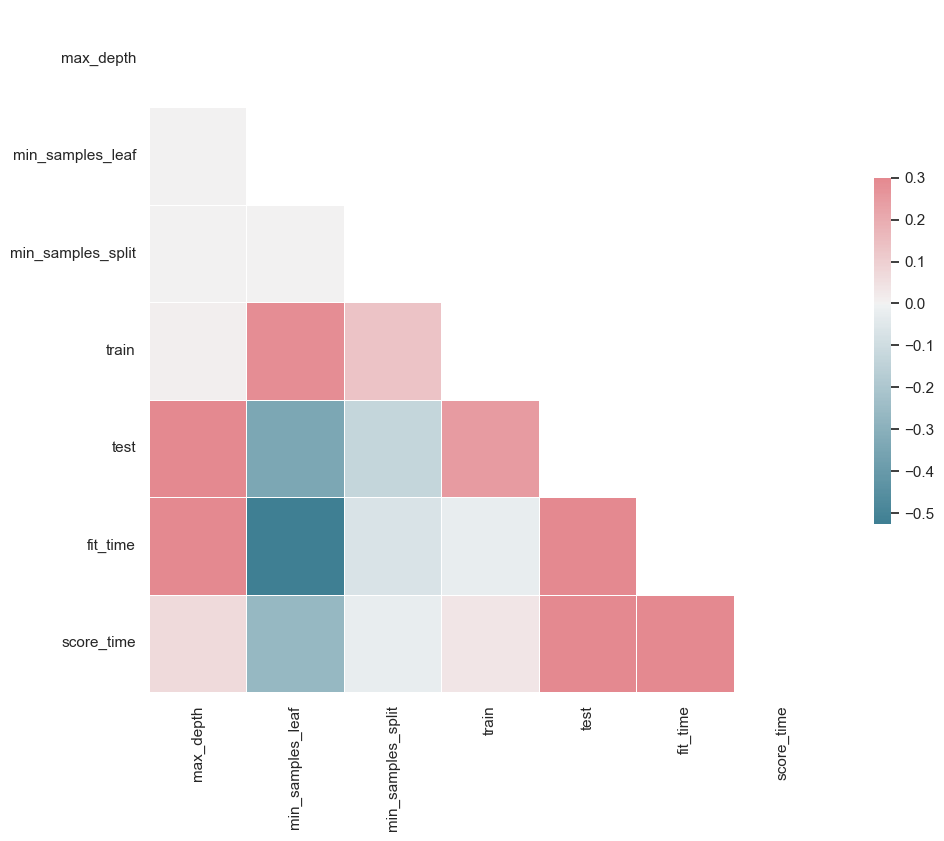

In [108]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [109]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007649,0.000672,0.001106,0.000212,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007451,0.000351,0.001199,0.000246,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.007301,0.000245,0.001199,0.000245,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007401,0.000200,0.001199,0.000244,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.007308,0.000324,0.001042,0.000155,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [110]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [111]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [112]:
from sklearn.metrics import accuracy_score
#evitar essa abordagem pois estara sendo otimista
predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes,y_azar)
print(accuracy)

0.7875


como ter uma estimativa sem esse vicio nos dados que eu ja vi?

no caso de cross validation com busca de hiper parametros , fazemos uma nova validação cruzada.
chama-se nested cross validation

In [113]:
from sklearn.model_selection import cross_val_score
#Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos.
cross_val_score(busca,x_azar,y_azar,cv=GroupKFold(n_splits=10),groups=dados.modelo)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 833, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
                                                              ^^^^^^^^
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 352, in split
    for train, test in super().split(X, y, groups):
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 85, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 97, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 530, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007099,0.000374,0.001400,0.000374,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006700,0.000246,0.001300,0.000245,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.006700,0.000245,0.001099,0.000200,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006800,0.000246,0.001400,0.000200,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.007000,0.000317,0.001401,0.000374,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [115]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [116]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

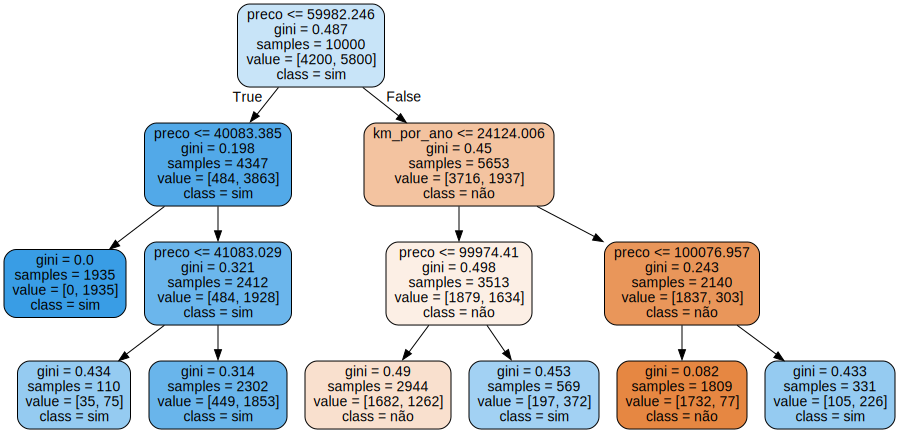

In [117]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph